In [132]:
from data_loader import dataloader
import os
import re
import pickle
import hashlib
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from os.path import isfile, isdir
from urllib.request import urlretrieve
from tensorflow.python.ops import math_ops
from sklearn.model_selection import train_test_split

In [133]:
tf.__version__

'2.8.0'

PREPROCESSING

In [134]:
user,ratings,movies = dataloader()
print(user.head())
print(movies.head())
print(ratings.head())

   user_id gender  age  occupation    zip
0        1      F    1          10  48067
1        2      M   56          16  70072
2        3      M   25          15  55117
3        4      M   45           7  02460
4        5      M   25          20  55455
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


In [135]:
ratings = ratings.filter(regex=('user_id|movie_id|rating'))
print(ratings)

         user_id  movie_id  rating
0              1      1193       5
1              1       661       3
2              1       914       3
3              1      3408       4
4              1      2355       5
...          ...       ...     ...
1000204     6040      1091       1
1000205     6040      1094       5
1000206     6040       562       5
1000207     6040      1096       4
1000208     6040      1097       4

[1000209 rows x 3 columns]


In [136]:
n_users = len(ratings.user_id.unique())
n_movies = len(ratings.movie_id.unique())
print("No of unique users:", n_users)
print("No of unique movies: ", n_movies, "\n")

No of unique users: 6040
No of unique movies:  3706 



In [137]:
gender_map = {'F':0, 'M':1}
user['gender'] = user['gender'].map(gender_map)
age_map = {val:idx for idx, val in enumerate(set(user['age']))}
user['age'] = user['age'].map(age_map)
users = user.filter(regex='user_id|gender|age|occupation')
users['user_inf'] = users.apply(lambda x: list([x['gender'],
                                        x['age'],
                                        x['occupation']]),axis=1) 
user_map = {}
for i in range(len(users['user_id'])):
    k = {users.iloc[i]['user_id']: np.array(users.iloc[i]['user_inf'])}
    user_map.update(k)

In [138]:
ratings['user_inf'] = ratings.loc[:, 'user_id']
ratings['user_inf'] = ratings['user_inf'].map(user_map)
ratings

,user_id,movie_id,rating,user_inf
0,1,1193,5,"[0, 0, 10]"
1,1,661,3,"[0, 0, 10]"
2,1,914,3,"[0, 0, 10]"
3,1,3408,4,"[0, 0, 10]"
4,1,2355,5,"[0, 0, 10]"
...,...,...,...,...
1000204,6040,1091,1,"[1, 6, 6]"
1000205,6040,1094,5,"[1, 6, 6]"
1000206,6040,562,5,"[1, 6, 6]"
1000207,6040,1096,4,"[1, 6, 6]"


In [139]:
movie_index_by_id = {id: i for i, id in enumerate(movies["movie_id"])}
# print(movie_index_by_id)
genres_set = (
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
)
genre_index_by_name = {name:i for i, name in enumerate(genres_set)}
print(genre_index_by_name)
print(type(movie_index_by_id[1]))
# print(type(movie_index_by_id[1]))
movies_map = {}
movie_features = np.zeros((len(movies), len(genres_set)))
for i in range(len(movies)):
    for genre in movies.iloc[i]['genres'].split("|"):        
        genre_index = genre_index_by_name[genre]
        movie_features[i, genre_index] = 1
    k = {movies.iloc[i]['movie_id']: movie_features[i]}
    movies_map.update(k)

{'Action': 0, 'Adventure': 1, 'Animation': 2, "Children's": 3, 'Comedy': 4, 'Crime': 5, 'Documentary': 6, 'Drama': 7, 'Fantasy': 8, 'Film-Noir': 9, 'Horror': 10, 'Musical': 11, 'Mystery': 12, 'Romance': 13, 'Sci-Fi': 14, 'Thriller': 15, 'War': 16, 'Western': 17}
<class 'int'>


In [140]:
ratings['movie_inf'] = ratings.loc[:, 'movie_id']
ratings['movie_inf'] = ratings['movie_inf'].map(movies_map)
ratings

,user_id,movie_id,rating,user_inf,movie_inf
0,1,1193,5,"[0, 0, 10]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
1,1,661,3,"[0, 0, 10]","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,914,3,"[0, 0, 10]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,3408,4,"[0, 0, 10]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,1,2355,5,"[0, 0, 10]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
1000204,6040,1091,1,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1000205,6040,1094,5,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
1000206,6040,562,5,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
1000207,6040,1096,4,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [141]:
map_2 = {}
movie_features = np.zeros((18, len(genres_set)))
for i in range(len(movie_features)):
    genre_index = i
    movie_features[i, genre_index] = 1
    k  = {3883+i: movie_features[i]}
    map_2.update(k)
map_2


{3883: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3884: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3885: array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3886: array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3887: array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3888: array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3889: array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3890: array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3891: array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3892: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3893: array([0., 0., 0., 0., 0., 0., 0.

In [142]:
user_prof1 = pd.read_csv('u_dict.csv')

In [143]:
user_prof1['user_inf'] = user_prof1.loc[:, 'user_id']
user_prof1['user_inf'] = user_prof1['user_inf'].map(user_map)
user_prof1

,user_id,genres,weight,user_inf
0,1,3883,4,"[0, 0, 10]"
1,1,3884,4,"[0, 0, 10]"
2,1,3885,4,"[0, 0, 10]"
3,1,3886,4,"[0, 0, 10]"
4,1,3887,4,"[0, 0, 10]"
...,...,...,...,...
93882,6040,3896,3,"[1, 6, 6]"
93883,6040,3897,3,"[1, 6, 6]"
93884,6040,3898,3,"[1, 6, 6]"
93885,6040,3899,3,"[1, 6, 6]"


In [144]:
user_prof1['movie_inf'] = user_prof1.loc[:, 'genres']
user_prof1['movie_inf'] = user_prof1['movie_inf'].map(map_2)
user_prof1


,user_id,genres,weight,user_inf,movie_inf
0,1,3883,4,"[0, 0, 10]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,3884,4,"[0, 0, 10]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3885,4,"[0, 0, 10]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,3886,4,"[0, 0, 10]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,3887,4,"[0, 0, 10]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
93882,6040,3896,3,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
93883,6040,3897,3,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
93884,6040,3898,3,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
93885,6040,3899,3,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


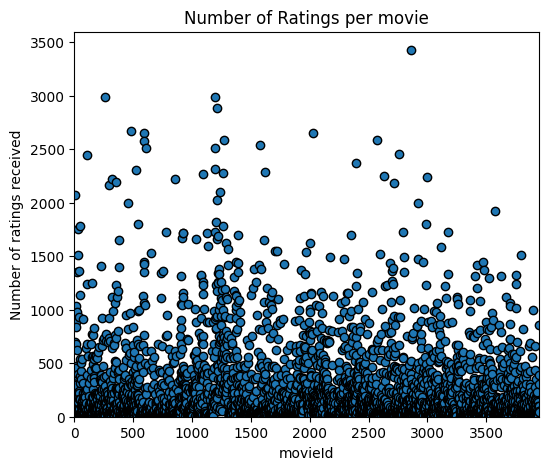

In [145]:
import matplotlib.pyplot as plt
rating_count = ratings[['movie_id','rating']].groupby(['movie_id']).count()
plt.figure(figsize=(6,5))
plt.scatter(rating_count.index, rating_count.rating, edgecolor='black')
plt.xlim(0,rating_count.index.max())
plt.ylim(0,)
plt.title('Number of Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

In [146]:
train, test = train_test_split(ratings, test_size= 0.2, random_state= 42)
train
user_prof1.rename(columns = {'genres':'movie_id', 'weight':'rating',
                              'movie_inf':'movie_inf'}, inplace = True)

In [147]:
train

,user_id,movie_id,rating,user_inf,movie_inf
416292,2507,3035,2,"[1, 6, 4]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
683230,4087,2840,4,"[1, 0, 4]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2434,19,457,3,"[1, 0, 10]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
688533,4118,2804,4,"[1, 6, 3]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
472584,2907,805,4,"[0, 1, 5]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...,...
259178,1586,1077,5,"[1, 2, 7]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
365838,2129,2700,5,"[1, 6, 5]","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
131932,854,3102,3,"[0, 6, 16]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
671155,4033,3479,5,"[1, 6, 6]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [148]:
train1 = pd.concat((train,user_prof1))
train1

,user_id,movie_id,rating,user_inf,movie_inf
416292,2507,3035,2,"[1, 6, 4]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
683230,4087,2840,4,"[1, 0, 4]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2434,19,457,3,"[1, 0, 10]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
688533,4118,2804,4,"[1, 6, 3]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
472584,2907,805,4,"[0, 1, 5]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...,...
93882,6040,3896,3,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
93883,6040,3897,3,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
93884,6040,3898,3,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
93885,6040,3899,3,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


NEURAL NETWORK BUILDING

In [149]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
import tensorflow as tf
     
#Creating movie embedding path
movie_input = Input(shape = (1,), name = "Movie-Input")
movie_embedding = Embedding(n_movies + 1, 10, name= "Movie-Embedding")(movie_input)
movie_vec = Flatten(name = "Flatten-Movies")(movie_embedding)

#Creating user embedding path
user_input = Input(shape = (1,), name = "User-Input")
user_embedding = Embedding(n_users + 1, 10, name = "User-Embedding")(user_input)
user_vec = Flatten(name = "Flatten-Users")(user_embedding)

#creating movie_inf embedding path
genres_input = Input(shape = (18,), name = "Genres-Input")
genres_embedding = Embedding(18, 5, name = "Genres-Embedding")(genres_input)
genres_vec = Flatten(name = "Flatten-Genres")(genres_embedding)


# Creating user_inf path
user_inf_input = Input(shape = (3,), name = "User_inf-Input")
# tf.convert_to_tensor(user_inf_input)
# user_inf_embedding = Embedding(n_users + 1, 10, name = "User_inf-Embedding")(user_inf_input)
user_inf_vec = Flatten(name = "Flatten_inf-Users")(user_inf_input)

#Concatenate features
conc = Concatenate()([movie_vec, user_vec, user_inf_vec, genres_vec])

#Weight Initialization
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1., seed = None)

#Add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(100, activation='relu')(fc1)
fc3 = Dense(80, activation='relu')(fc2)
fc4 = Dense(60, activation='relu')(fc3)
fc5 = Dense(32, activation='relu')(fc4)
out = Dense(1)(fc5)

#Create model and compile it
model = Model([[user_input, movie_input], user_inf_input,genres_input], out)
model.compile('adam', 'mean_squared_error')

In [150]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Movie-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Genres-Input (InputLayer)      [(None, 18)]         0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 10)        37070       ['Movie-Input[0][0]']            
                                                                                            

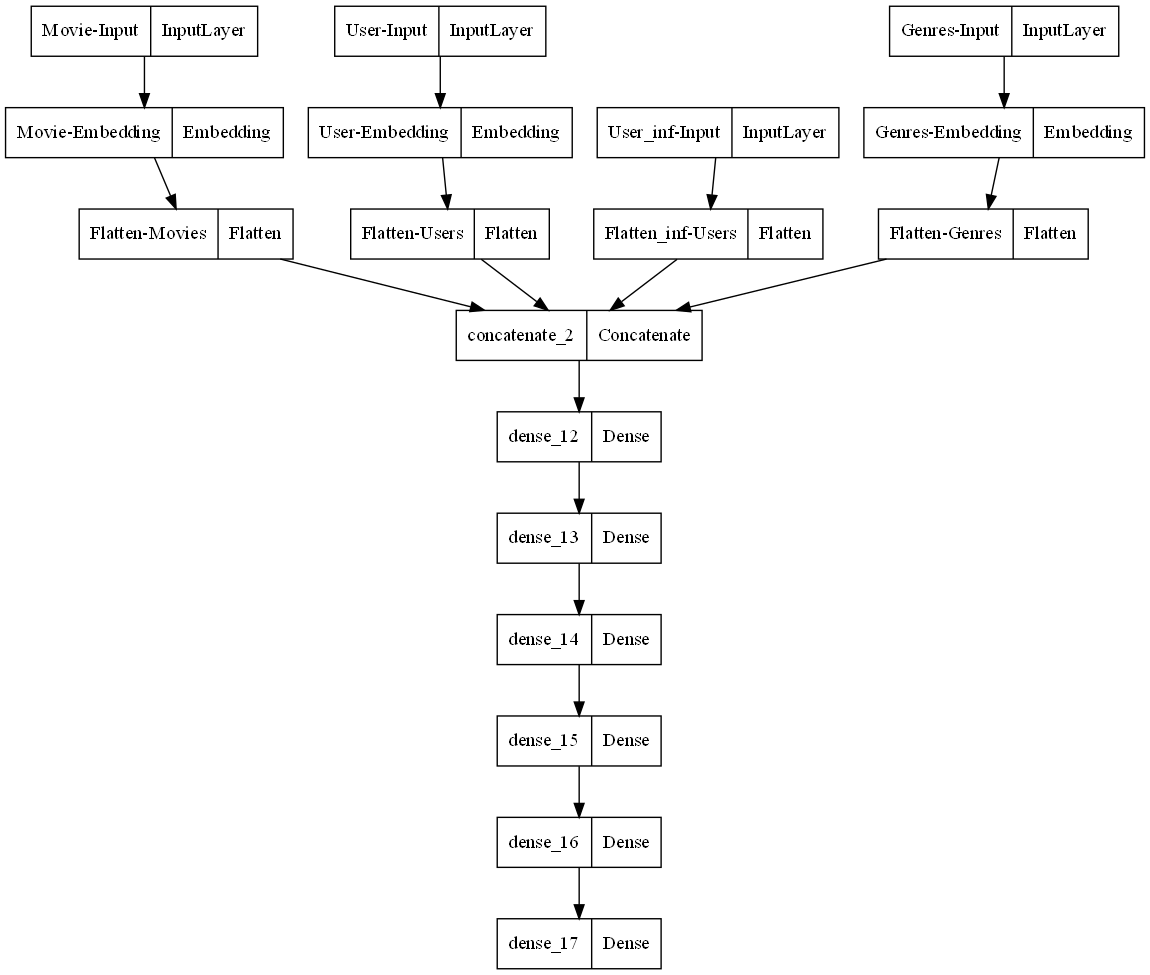

In [151]:
from keras.utils.vis_utils import plot_model
plot_model(model, rankdir= 'TR', dpi = 100)

In [152]:
[print(i.shape, i.dtype) for i in model.inputs]

(None, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
(None, 3) <dtype: 'float32'>
(None, 18) <dtype: 'float32'>


[None, None, None, None]

In [153]:
train.user_inf

416292     [1, 6, 4]
683230     [1, 0, 4]
2434      [1, 0, 10]
688533     [1, 6, 3]
472584     [0, 1, 5]
             ...    
259178     [1, 2, 7]
365838     [1, 6, 5]
131932    [0, 6, 16]
671155     [1, 6, 6]
121958     [1, 6, 0]
Name: user_inf, Length: 800167, dtype: object

In [154]:
np.array([np.array(val) for val in train.user_inf]).shape
np.array([np.array(val) for val in train.movie_inf]).shape

(800167, 18)

In [155]:
train.movie_id.shape

(800167,)

In [156]:
history = model.fit([[train.user_id, train.movie_id],np.array([np.array(val) for val in train.user_inf]), np.array([np.array(val) for val in train.movie_inf])], train.rating, epochs = 18, verbose = 1)

Epoch 1/18
25006/25006 [==============================] - 220s 9ms/step - loss: 0.8912
Epoch 2/18
25006/25006 [==============================] - 231s 9ms/step - loss: 0.8180
Epoch 3/18
25006/25006 [==============================] - 240s 10ms/step - loss: 0.7923
Epoch 4/18
25006/25006 [==============================] - 250s 10ms/step - loss: 0.7695
Epoch 5/18
25006/25006 [==============================] - 254s 10ms/step - loss: 0.7525
Epoch 6/18
25006/25006 [==============================] - 257s 10ms/step - loss: 0.7384
Epoch 7/18
25006/25006 [==============================] - 240s 10ms/step - loss: 0.7257
Epoch 8/18
25006/25006 [==============================] - 266s 11ms/step - loss: 0.7157
Epoch 9/18
25006/25006 [==============================] - 289s 12ms/step - loss: 0.7071
Epoch 10/18
25006/25006 [==============================] - 288s 12ms/step - loss: 0.6996
Epoch 11/18
25006/25006 [==============================] - 292s 12ms/step - loss: 0.6926
Epoch 12/18
25006/25006 [=======

In [157]:
model.save('Neural_RS')

INFO:tensorflow:Assets written to: Neural_RS\assets


INFO:tensorflow:Assets written to: Neural_RS\assets


In [158]:
from keras.models import load_model
model = load_model("Neural_RS")

In [159]:
item_data = np.array(list(set(ratings.movie_id)))
item_data[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [160]:
user = np.array([1 for i in range(len(item_data))])
user[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [161]:
user_inf_pre = np.array([np.array([0, 0, 10]) for i in range(len(item_data))])
user_inf_pre

array([[ 0,  0, 10],
       [ 0,  0, 10],
       [ 0,  0, 10],
       ...,
       [ 0,  0, 10],
       [ 0,  0, 10],
       [ 0,  0, 10]])

In [162]:
train.movie_inf[1]

array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.])

In [163]:
movie_inf_pre = np.array([np.array(movies_map[i]) for i in item_data])
movie_inf_pre



array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [164]:
predictions = model.predict([[user,item_data],user_inf_pre,movie_inf_pre])
predictions

array([[4.74533  ],
       [3.932951 ],
       [3.7912314],
       ...,
       [3.58469  ],
       [3.58469  ],
       [3.48578  ]], dtype=float32)

In [165]:
predictions = np.array([a[0] for a in predictions])
recommended_movie = predictions[::-1].argsort()[:10]
recommended_movie


array([ 282,  369, 1896, 2672,  368, 2479, 3491, 3469, 3641, 1385],
      dtype=int64)

In [166]:
movies[movies['movie_id'].isin(recommended_movie)]

,movie_id,title,genres
279,282,Nell (1994),Drama
364,368,Maverick (1994),Action|Comedy|Western
365,369,Mrs. Parker and the Vicious Circle (1994),Drama
1364,1385,Under Siege (1992),Action
1827,1896,Cousin Bette (1998),Comedy
2410,2479,Gloria (1999),Drama|Thriller
2603,2672,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller
3400,3469,Inherit the Wind (1960),Drama
3422,3491,My Chauffeur (1986),Comedy
3572,3641,"Woman of Paris, A (1923)",Drama


In [167]:
model.evaluate([[test.user_id, test.movie_id], np.array([np.array(val) for val in test.user_inf]), np.array([np.array(val) for val in test.movie_inf]) ], test.rating)

6252/6252 [==============================] - 21s 3ms/step - loss: 0.7670


0.7669686079025269